# Example: Explore ion binding data

We want to analyze the binding behavior of sodium ions with respect to a number residues on our protein. A simple, first-order approach is to get the minimum distance between the residues. We want to get this efficiently for every frame and into a form that we can easily use for data exploration.

We have written a module with a class that will efficiently get the data elements we need to start answering our question. We'll import it, as well as MDAnalysis, so we can feed it an MDAnalysis.Universe corresponding to our simulation data.

In [1]:
import MDAnalysis as md
from MDAnalysisTests.datafiles import GRO, XTC
import binding

We'll use an example system from the MDAnalysisTests datafiles.

In [2]:
u = md.Universe(GRO, XTC)

In [3]:
u.trajectory.numframes

10

The trajectory is rather short, so this will be quick.

In [4]:
# first we feed the analysis class the information it wants
b = binding.Binding(u, resids=[107, 123], ion='NA+')

In [5]:
# then we run it!
b.run()

/usr/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '107'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


Analyzing frame 9/10, time 800.000061035 ps


Our data is now stored in an HDF5 file, a fileformat that is optimized especially for tabular data like ours. This is generally better than text files (CSV, JSON, XVG) in terms of read/write times and file size, and it also allows on-the-fly compression, which can reduce these further. HDF5 also allows out-of-core querying of data, which means subsets of a dataset that is many times larger than a machine's memory can conveniently be analyzed. The benefits are many.

## Accessing HDF5 data

We wrote our data as pandas DataFrames using the HDFStore object in pandas. We can use the same to read it back.

In [6]:
import pandas

In [7]:
f = pandas.HDFStore('iondata.h5', 'r')

In [8]:
f

<class 'pandas.io.pytables.HDFStore'>
File path: iondata.h5
/107            frame_table  (typ->appendable,nrows->9,ncols->8,indexers->[index],dc->[dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4])
/123            frame_table  (typ->appendable,nrows->9,ncols->8,indexers->[index],dc->[dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4])

HDF5 files can contain multiple datasets, and they can have an internal structure like a filesystem. Our analysis class saved the data for each residue as separate tables, and we can access them separately.

In [9]:
f['107']

,dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4
time,,,,,,,,
0.000000,15.066098,47679,19.219854,47680,26.714713,47677,50.098661,47678
100.000008,15.826400,47679,31.996546,47677,56.059958,47678,60.527775,47680
200.000015,17.555090,47679,46.930643,47680,51.383418,47678,57.654267,47677
300.000000,8.951816,47679,31.798067,47677,44.086889,47680,54.578458,47678
400.000031,12.269272,47679,45.491886,47680,54.340629,47678,54.709148,47677
500.000031,19.118078,47679,42.535654,47680,44.204339,47678,67.778096,47677
600.000000,14.667817,47679,35.299042,47680,49.970065,47678,57.201385,47677
700.000061,22.473081,47679,33.302190,47680,57.235334,47677,69.811178,47678
800.000061,21.190881,47679,36.234801,47680,38.298401,47677,65.976435,47678


In [10]:
f['123']

,dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4
time,,,,,,,,
0.000000,22.074248,47677,29.620570,47680,36.947619,47679,47.725534,47678
100.000008,26.478021,47677,38.400472,47679,52.077026,47678,79.535246,47680
200.000015,39.782146,47679,49.120996,47677,67.598039,47680,73.043726,47678
300.000000,17.265255,47677,33.435300,47679,62.951470,47680,76.225206,47678
400.000031,36.577757,47679,45.294870,47677,65.207431,47680,77.449930,47678
500.000031,37.115365,47678,39.873178,47679,57.555616,47680,84.092972,47677
600.000000,34.894438,47679,48.372478,47677,52.610892,47680,72.716770,47678
700.000061,45.321686,47679,49.498554,47677,51.005083,47680,89.045049,47678
800.000061,44.671225,47679,49.036387,47680,56.056482,47677,82.712491,47678


These are returned as pandas DataFrames, just as we stored them. In this example the DataFrames are rather small, but HDF5 files can store terabytes of data just as efficiently, so our analysis code can scale up just fine. Even though each DataFrame is small enough to fit in memory, we can still try a query!

In [11]:
f.select('123', where='dist1 < 30')

,dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4
time,,,,,,,,
0.000000,22.074248,47677,29.620570,47680,36.947619,47679,47.725534,47678
100.000008,26.478021,47677,38.400472,47679,52.077026,47678,79.535246,47680
300.000000,17.265255,47677,33.435300,47679,62.951470,47680,76.225206,47678


We were able to get back only those rows for which ``dist1`` < 30. If this were a dataset larger than our computer's available memory, this query would still work, since the amount of memory needed is only as large as the query's result! This is a valuable feature, and it is *fast*.

The HDFStore object also allows selection of only particular columns...

In [12]:
f.select('107', columns=['dist2', 'ion3'])

,dist2,ion3
time,,
0.000000,19.219854,47677
100.000008,31.996546,47678
200.000015,46.930643,47678
300.000000,31.798067,47680
400.000031,45.491886,47678
500.000031,42.535654,47678
600.000000,35.299042,47678
700.000061,33.302190,47677
800.000061,36.234801,47677


...and these can be combined with queries against other columns.

In [13]:
f.select('107', columns=['dist2', 'ion3'], where='dist4 < 60 and dist1 > 15')

,dist2,ion3
time,,
0.000000,19.219854,47677
200.000015,46.930643,47678


## Data exploration with pandas

Pandas DataFrames provide a convenient data structure for dealing with data, and possibly large amounts of it. A DataFrame is a basically a table, but under the hood, a DataFrame is essentially a dictionary of 1-D numpy arrays It is also more than that: numpy makes DataFrames effecient, but a DataFrame has machinery built in to easily handle columns with missing values. It can also perform SQL-like functionality, such as grouping the contents of a DataFrame by the contents of a particular column (also known as a ``groupby``).

In [14]:
df = f['123']

In [15]:
f.close()

DataFrames can give convenient summary statistics.

In [16]:
df.describe()

,dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,33.797793,47678.222222,42.516978,47678.333333,55.778851,47679.333333,75.838547,47678.111111
std,9.817883,0.971825,7.496593,1.322876,9.249428,1.118034,11.800996,0.781736
min,17.265255,47677.000000,29.620570,47677.000000,36.947619,47677.000000,47.725534,47677.000000
25%,26.478021,47677.000000,38.400472,47677.000000,52.077026,47679.000000,73.043726,47678.000000
50%,36.577757,47679.000000,45.294870,47679.000000,56.056482,47680.000000,77.449930,47678.000000
75%,39.782146,47679.000000,49.036387,47679.000000,62.951470,47680.000000,82.712491,47678.000000
max,45.321686,47679.000000,49.498554,47680.000000,67.598039,47680.000000,89.045049,47680.000000


And we can look at only columns we care about, too.

In [17]:
df[['dist1', 'dist2']]

,dist1,dist2
time,,
0.000000,22.074248,29.620570
100.000008,26.478021,38.400472
200.000015,39.782146,49.120996
300.000000,17.265255,33.435300
400.000031,36.577757,45.294870
500.000031,37.115365,39.873178
600.000000,34.894438,48.372478
700.000061,45.321686,49.498554
800.000061,44.671225,49.036387


In [18]:
df[['dist1', 'dist2']].describe()

,dist1,dist2
count,9.000000,9.000000
mean,33.797793,42.516978
std,9.817883,7.496593
min,17.265255,29.620570
25%,26.478021,38.400472
50%,36.577757,45.294870
75%,39.782146,49.036387
max,45.321686,49.498554


DataFrames can be filtered by conditioning on their column values, too.

In [19]:
df[ df['dist2'] < 40 ]

,dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4
time,,,,,,,,
0.000000,22.074248,47677,29.620570,47680,36.947619,47679,47.725534,47678
100.000008,26.478021,47677,38.400472,47679,52.077026,47678,79.535246,47680
300.000000,17.265255,47677,33.435300,47679,62.951470,47680,76.225206,47678
500.000031,37.115365,47678,39.873178,47679,57.555616,47680,84.092972,47677


And plotting is super convenient.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

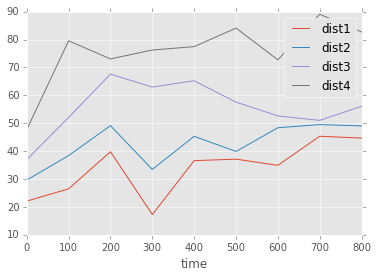

In [21]:
df[['dist1', 'dist2', 'dist3', 'dist4']].plot()

Even though we don't really see ion binding in this example, what if we wanted to know how many *different* ions were nearest a residue of interest? We could use a ``groupby`` to make this easy.

We basically want to know how many different unique values there are in column ``ion1``. First, the groupby.

In [22]:
g = df.groupby('ion1')

In [23]:
g.groups

{47677: [0.0, 100.00000762939453, 300.0],
 47678: [500.0000305175781],
 47679: [200.00001525878906,
  400.0000305175781,
  600.0,
  700.0000610351562,
  800.0000610351562]}

Notice that a groupby makes a dictionary with keys being values in the selected column and the values being a list of the indexes for the rows containing that value. We can DataFrames corresponding to these specific values directly.

In [24]:
g.get_group(47677)

,dist1,ion1,dist2,ion2,dist3,ion3,dist4,ion4
time,,,,,,,,
0.000000,22.074248,47677,29.620570,47680,36.947619,47679,47.725534,47678
100.000008,26.478021,47677,38.400472,47679,52.077026,47678,79.535246,47680
300.000000,17.265255,47677,33.435300,47679,62.951470,47680,76.225206,47678


Notice that this is only the rows of our original DataFrame for which ``ion1`` == 47677. We could have gotten this with filtering, but a groupby can do much more. We wanted to know how many different ions were nearest our residue. We see immediately that there are three.

In [25]:
g.groups.keys()

[47677, 47678, 47679]

How many times is each one present?

In [26]:
g['ion1'].count()

ion1
47677    3
47678    1
47679    5
Name: ion1, dtype: int64

We can also groupby multiple columns at once. Say we choose the nearest two ions.

In [27]:
g2 = df.groupby(('ion1', 'ion2'))

In [28]:
g2.groups

{(47677, 47679): [100.00000762939453, 300.0],
 (47677, 47680): [0.0],
 (47678, 47679): [500.0000305175781],
 (47679, 47677): [200.00001525878906,
  400.0000305175781,
  600.0,
  700.0000610351562],
 (47679, 47680): [800.0000610351562]}

This groups by each pair of atom indices present. We could go further and group by the nearest three.

In [29]:
g3 = df.groupby(('ion1', 'ion2', 'ion3'))

In [30]:
g3.groups

{(47677, 47679, 47678): [100.00000762939453],
 (47677, 47679, 47680): [300.0],
 (47677, 47680, 47679): [0.0],
 (47678, 47679, 47680): [500.0000305175781],
 (47679, 47677, 47680): [200.00001525878906,
  400.0000305175781,
  600.0,
  700.0000610351562],
 (47679, 47680, 47677): [800.0000610351562]}

Or even all four we collected data for. This gets the indices for every combination of the ions present in the four columns. Of course with such a small dataset, there isn't much useful here, but the same could be applied to a dataset with much better sampling.

In [31]:
g4 = df.groupby(('ion1', 'ion2', 'ion3', 'ion4'))

In [32]:
g4.groups

{(47677, 47679, 47678, 47680): [100.00000762939453],
 (47677, 47679, 47680, 47678): [300.0],
 (47677, 47680, 47679, 47678): [0.0],
 (47678, 47679, 47680, 47677): [500.0000305175781],
 (47679, 47677, 47680, 47678): [200.00001525878906,
  400.0000305175781,
  600.0,
  700.0000610351562],
 (47679, 47680, 47677, 47678): [800.0000610351562]}

A ``groupby`` can also allow for useful plotting. By plotting ``dist1`` using the ``groupby``, we can see visually which binding distances correspond to each ion.

ion1
47677    Axes(0.125,0.125;0.775x0.775)
47678    Axes(0.125,0.125;0.775x0.775)
47679    Axes(0.125,0.125;0.775x0.775)
Name: dist1, dtype: object

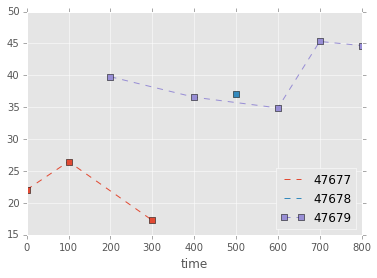

In [33]:
g['dist1'].plot(style='s--', legend=True)

There's plenty more to pandas, but hopefully this introduction has given you ideas for how to improve aspects of your own workflow. If you found this style of working with molecular dynamics data appealing, I suggest you have a look at MDSynthesis, a python package that makes data storage, retrieval, and exploration easier, especially when that data comes from a diverse set of simulations: http://mdsynthesis.readthedocs.org/